In [1]:
import pypsa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cartopy.crs as ccrs
from pypsa.linopt import get_var, linexpr, define_constraints
from geopy.geocoders import Nominatim
from geopy import distance

In [2]:
def get_electrical_data(years_elect):
    if years_elect == [2030]:
        return "C:/Users/work/pypsa_thesis/data/electrical/1_2030"
    elif years_elect == [2040]:
        return "C:/Users/work/pypsa_thesis/data/electrical/2_2040"
    elif years_elect == [2050]:
        return "C:/Users/work/pypsa_thesis/data/electrical/3_2050"


def get_hydrogen_data(scenario_h2, years_h2):
    if scenario_h2 == 'TN-H2-G':
        if years_h2 == [2030]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2030.csv",
                                      index_col=0)

        elif years_h2 == [2040]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2040.csv",
                                      index_col=0)

        elif years_h2 == [2050]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-H2-G/BW_2050.csv",
                                      index_col=0)

    elif scenario_h2 == 'TN-PtG-PtL':
        if years_h2 == [2030]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2030.csv",
                                      index_col=0)

        elif years_h2 == [2040]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2040.csv",
                                      index_col=0)

        elif years_h2 == [2050]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-PtG-PtL/BW_2050.csv",
                                      index_col=0)

    elif scenario_h2 == 'TN-Strom':
        if years_h2 == [2030]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2030.csv",
                                      index_col=0)

        elif years_h2 == [2040]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2040.csv",
                                      index_col=0)

        elif years_h2 == [2050]:
            load_data = pd.read_csv("C:/Users/work/pypsa_thesis/data/hydrogen/TN-Strom/BW_2050.csv",
                                      index_col=0)

    df_h2_demand = pd.DataFrame(load_data)
    df_h2_demand.index.names = ['location_name']
    df_h2_demand.reset_index(inplace=True)
    df_h2_demand.dropna(subset=['location_name'], inplace=True)

    for loc_count in range(len(df_h2_demand['location_name'])):
        geolocator = Nominatim(user_agent="locate_h2_demand")
        locate_h2_demand = geolocator.geocode(df_h2_demand['location_name'][loc_count].split(',')[0])
        df_h2_demand['x'][loc_count] = locate_h2_demand.longitude
        df_h2_demand['y'][loc_count] = locate_h2_demand.latitude

    df_ac_loads_h2_loads_dist = pd.DataFrame(index=network.loads.index, columns=df_h2_demand['location_name'])

    for city_count_x in range(len(network.loads.index)):
        for city_count_y in range(len(df_h2_demand['location_name'])):
            if network.loads.index[city_count_x] != df_h2_demand['location_name'][city_count_y]:
                city_1 = (network.loads['y'][city_count_x], network.loads['x'][city_count_x])
                city_2 = (df_h2_demand['y'][city_count_y], df_h2_demand['x'][city_count_y])
                dist_city1_city2 = distance.distance(city_1, city_2).km
                df_ac_loads_h2_loads_dist.at[
                    network.loads.index[city_count_x], df_h2_demand['location_name'][city_count_y]] = dist_city1_city2

    ac_loads_h2_links = []

    for column_count_x in df_ac_loads_h2_loads_dist.columns:
        for distance_count_x in range(len(df_ac_loads_h2_loads_dist[column_count_x])):
            if df_ac_loads_h2_loads_dist[column_count_x][distance_count_x] == \
                    df_ac_loads_h2_loads_dist[column_count_x].min():
                ac_loads_h2_links.append(df_ac_loads_h2_loads_dist.index[distance_count_x])

    ac_loads_h2_links = list(dict.fromkeys(ac_loads_h2_links))

    df_h2_buses_load = pd.DataFrame(index=ac_loads_h2_links, columns={'h2_load': [], 'x': [], 'y': []})

    for buses_count in range(len(network.buses.index)):
        for h2_buses_count in range(len(df_h2_buses_load.index)):
            if network.buses.index[buses_count] == df_h2_buses_load.index[h2_buses_count]:
                df_h2_buses_load['x'][h2_buses_count] = network.buses['x'][buses_count]
                df_h2_buses_load['y'][h2_buses_count] = network.buses['y'][buses_count]

    df_h2_buses_load.fillna(0, inplace=True)

    for column_count_y, i_count_y in zip(df_ac_loads_h2_loads_dist.columns, range(len(df_h2_demand['location_name']))):
        for distance_count_y in range(len(df_ac_loads_h2_loads_dist[column_count_y])):
            if df_ac_loads_h2_loads_dist[column_count_y][distance_count_y] == \
                    df_ac_loads_h2_loads_dist[column_count_y].min():
                h2_load_value = df_h2_demand[df_h2_demand['location_name'] == column_count_y]['demand_value'][
                                    i_count_y] * 1e6  # in MWh
                h2_demand_loc = df_ac_loads_h2_loads_dist.index[distance_count_y]
                if df_h2_buses_load.at[h2_demand_loc, 'h2_load'] == 0:
                    df_h2_buses_load.at[h2_demand_loc, 'h2_load'] = h2_load_value
                else:
                    df_h2_buses_load.at[h2_demand_loc, 'h2_load'] = df_h2_buses_load.at[h2_demand_loc, 'h2_load'] + \
                                                                    h2_load_value

    df_h2_pipelines_dist = pd.DataFrame(index=ac_loads_h2_links, columns=ac_loads_h2_links)

    for column_count_z in range(len(list(df_h2_pipelines_dist.index))):
        for row_count_z in range(len(list(df_h2_pipelines_dist.columns))):
            if df_h2_pipelines_dist.index[column_count_z] != df_h2_pipelines_dist.columns[row_count_z]:
                loc_1 = (df_h2_buses_load['y'][column_count_z], df_h2_buses_load['x'][column_count_z])
                loc_2 = (df_h2_buses_load['y'][row_count_z], df_h2_buses_load['x'][row_count_z])
                dist_loc_1_loc_2 = distance.distance(loc_1, loc_2).km
                df_h2_pipelines_dist.at[
                    df_h2_pipelines_dist.columns[row_count_z], df_h2_pipelines_dist.index[column_count_z]] = \
                    dist_loc_1_loc_2

    h2_pipe_row_list = []
    h2_bus_0_list = []
    h2_bus_1_list = []
    bus_0_list = []
    bus_1_list = []
    distance_km_list = []

    for city_count_p in list(df_h2_pipelines_dist.columns):
        for city_count_q in range(len(list(df_h2_pipelines_dist.index))):
            if df_h2_pipelines_dist[city_count_p][city_count_q] == \
                    df_h2_pipelines_dist[city_count_p].min():
                h2_pipe_row_list.append('{}_{}_h2_pipe'.format(city_count_p, df_h2_pipelines_dist.index[city_count_q]))
                h2_bus_0_list.append('{}_H2_Bus'.format(city_count_p))
                h2_bus_1_list.append('{}_H2_Bus'.format(df_h2_pipelines_dist.index[city_count_q]))
                bus_0_list.append(city_count_p)
                bus_1_list.append(df_h2_pipelines_dist.index[city_count_q])
                distance_km_list.append(df_h2_pipelines_dist[city_count_p].min())

    df_h2_pipelines = pd.DataFrame(index=h2_pipe_row_list)
    df_h2_pipelines.index.names = ['H2_pipelines']

    df_h2_pipelines['bus_0'] = h2_bus_0_list
    df_h2_pipelines['bus_1'] = h2_bus_1_list
    df_h2_pipelines['distance_km'] = distance_km_list

    all_bus_list = bus_0_list + bus_1_list
    connected_list = []

    for city_check in ac_loads_h2_links:
        if city_check not in all_bus_list:
            print('{} not connected to any bus'.format(city_check))
        else:
            connected_list.append('{} is connected to a H2 bus'.format(city_check))

    dict_h2_data = {'h2_links': ac_loads_h2_links,
                    'h2_dataframe': df_h2_demand,
                    'h2_buses_load': df_h2_buses_load,
                    'h2_pipelines': df_h2_pipelines,
                    'h2_demand_value_total': round(sum(df_h2_demand['demand_value']) * 1e6, 2)}  # in MWh

    return dict_h2_data


# choose which year to simulate

years = [2030]  # [2030] or [2040] or [2050]

# choose which hydrogen demand scenario to simulate

h2_scenario_demand = "TN-H2-G"  # "TN-H2-G" or "TN-PtG-PtL" or "TN-Strom"

freq = "24"

network = pypsa.Network(get_electrical_data(years))

snapshots = pd.DatetimeIndex([])
for year in years:
    period = pd.date_range(start='{}-01-01 00:00'.format(year),
                           freq='{}H'.format(freq),
                           periods=8760 / float(freq))
    snapshots = snapshots.append(period)

network.snapshots = pd.MultiIndex.from_arrays([snapshots.year, snapshots])

# network.snapshots

'''

Nyears value depends on the snapshot resolution freq variable
current freq = 24 with Nyears value of = 0.041666666666666664
Change of Nyears value will affect the calculation of capital cost using pypsa-eur methodology from 
the add_electricity script

costs["capital_cost"] = ((annuity(costs["lifetime"], costs["discount rate"]) + 
                            costs["FOM"]/100.) *
                            costs["investment"] * Nyears)
                            
'''
# Nyears = network.snapshot_weightings.objective.sum() / 8760
# Nyears

pmaxpu_generators = network.generators[
    (network.generators['carrier'] == 'Solar') |
    (network.generators['carrier'] == 'Wind_Offshore') |
    (network.generators['carrier'] == 'Wind_Onshore')]

network.generators_t.p_max_pu = network.generators_t.p_max_pu.reindex(columns=pmaxpu_generators.index)

network.generators_t.p_max_pu.loc[:, pmaxpu_generators.index] = pd.DataFrame(index=network.snapshots,
                                                                             columns=pmaxpu_generators.index,
                                                                             data=np.random.rand(len(network.snapshots),
                                                                                                 len(pmaxpu_generators)))

h2_data = get_hydrogen_data(h2_scenario_demand, years)

# connect between electrical buses and hydrogen bus via link (as electrolysis unit)

df_h2_buses_load = pd.DataFrame(h2_data['h2_buses_load'])
df_h2_pipes = pd.DataFrame(h2_data['h2_pipelines'])

h2_buses_names = list(df_h2_buses_load.index)

h2_buses = [x + '_H2_Bus' for x in h2_buses_names]

network.madd('Bus',
             h2_buses,
             carrier='Hydrogen',
             x=list(df_h2_buses_load['x']),
             y=list(df_h2_buses_load['y'])
             )

# electrolysis capital cost and efficiency are based on DEA agency data and pypsa methodology calculations

electrolysis_cap_cost = 0
electrolysis_efficiency = 0

if years == [2030]:
    electrolysis_cap_cost = 1886
    electrolysis_efficiency = 0.68
elif years == [2040]:
    electrolysis_cap_cost = 1238.41
    electrolysis_efficiency = 0.72
elif years == [2050]:
    electrolysis_cap_cost = 1012.85
    electrolysis_efficiency = 0.75

h2_links = [s + '_Electrolysis' for s in h2_buses_names]

network.madd('Link',
             h2_links,
             carrier='Hydrogen',
             capital_cost=electrolysis_cap_cost,
             p_nom_extendable=True,
             bus0=h2_buses_names,
             bus1=h2_buses,
             efficiency=electrolysis_efficiency)

if years == [2030]:
    h2_pipe_cap_cost = 982.88
elif years == [2040]:
    h2_pipe_cap_cost = 903.61
elif years == [2050]:
    h2_pipe_cap_cost = 825.29

network.madd("Link",
             df_h2_pipes.index,
             bus0=list(df_h2_pipes['bus_0']),
             bus1=list(df_h2_pipes['bus_1']),
             p_min_pu=-1,
             p_nom_extendable=True,
             length=list(df_h2_pipes['distance_km']),
             capital_cost=h2_pipe_cap_cost * df_h2_pipes['distance_km'],
             efficiency=0.98,  # value from pypsa-eur
             carrier="Hydrogen")

h2_stores = [y + '_H2_Store' for y in h2_buses_names]

network.madd('Store',
             h2_stores,
             bus=h2_buses,
             carrier='Hydrogen',
             e_nom_extendable=True)

h2_loads = [z + '_H2_Load' for z in h2_buses_names]

network.madd('Load',
             h2_loads,
             bus=h2_buses,
             p_set=list(df_h2_buses_load['h2_load']),
             carrier='Hydrogen',
             x=list(df_h2_buses_load['x']),
             y=list(df_h2_buses_load['y'])
             )

ac_loads = network.loads[(network.loads['carrier'] == 'AC')]

network.loads_t.p_set = pd.DataFrame(index=network.snapshots,
                                     columns=ac_loads.index,
                                     data=100 * np.random.rand(len(network.snapshots), len(ac_loads)))




INFO:pypsa.io:Imported network 2_2040 has buses, carriers, generators, global_constraints, lines, loads, storage_units, transformers
C:\Users\HP Elitebook 840\AppData\Local\Temp\ipykernel_6304\314581525.py:58: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\HP Elitebook 840\AppData\Local\Temp\ipykernel_6304\314581525.py:59: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [8]:
#output to csv
#network.links_t.p0

dfnetworklinks = pd.DataFrame(network.links)
os.makedirs('network_links', exist_ok=True)  
dfnetworklinks.to_csv('dfnetworklinks.csv') 

In [95]:
# for electrolysis

elec_list = []

for y in network.links.index:
    if '_Electrolysis' in y.split('110kV'):
        elec_list.append(y)

In [96]:
# for h2 pipes

h2_pipe_list = []
for x in network.links.index:
    if '_h2_pipe' in x.split('110kV'):
        h2_pipe_list.append(x)
        

In [97]:
elec_list = pd.Series('red', elec_list)

In [98]:
h2_pipe_list = pd.Series('green', h2_pipe_list)

In [99]:
line_colors = pd.Series('white', network.lines.index)

In [100]:
bus_colors = pd.Series("blue", network.buses.index)

In [104]:
bus_colors

Bus
KarlsruheWest_220kV                 blue
KarlsruheWest_110kV                 blue
Daxlanden_110kV                     blue
Daxlanden_220kV                     blue
Daxlanden_380kV                     blue
                                    ... 
Tuttlingen_110kV_H2_Bus             blue
Rappenberghalde_110kV_H2_Bus        blue
UlmOst_110kV_H2_Bus                 blue
Gurtweil_110kV_H2_Bus               blue
Laufen_an_der_Eyach_110kV_H2_Bus    blue
Length: 196, dtype: object

In [101]:
link_colors = elec_list.append(h2_pipe_list)

C:\Users\HP Elitebook 840\AppData\Local\Temp\ipykernel_6304\3232894932.py:1: FutureWarning:

The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



In [103]:
link_colors

Schmiechen_110kV_Electrolysis                           red
Kuppenheim_110kV_Electrolysis                           red
Biberach_110kV_Electrolysis                             red
Markdorf_110kV_Electrolysis                             red
Eichstetten_110kV_Electrolysis                          red
                                                      ...  
Tuttlingen_110kV_Trossingen_110kV_h2_pipe             green
Rappenberghalde_110kV_Reutlingen_110kV_h2_pipe        green
UlmOst_110kV_Schmiechen_110kV_h2_pipe                 green
Gurtweil_110kV_Lorrach_110kV_h2_pipe                  green
Laufen_an_der_Eyach_110kV_Trossingen_110kV_h2_pipe    green
Length: 76, dtype: object

(<matplotlib.collections.PatchCollection at 0x277b77a5f40>,
 <matplotlib.collections.LineCollection at 0x277b89984f0>)

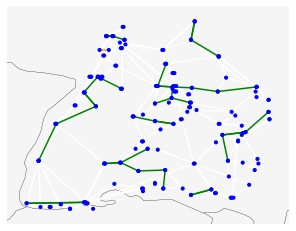

In [102]:
network.plot(margin=0.08, bus_sizes = 0.0005, bus_colors = bus_colors, 
             color_geomap=True, link_colors = link_colors, line_colors = line_colors)

In [ ]:
network.lopf(pyomo=False, solver_name='gurobi')

In [ ]:
network.generators.p_nom_opt.plot.bar(ylabel='MW', figsize=(15,10))
plt.tight_layout()